In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, CategoricalParameter, Constant
import time

In [2]:
seeds = [259572, 7542, 864199, 11540, 188813, 411862, 546078, 420812, 304196, 814030]

In [3]:
# r, v, p_b, stations_to_place, station_cap, max_per_loc, o=24, load=1,

In [4]:
%%time
# r, v, p_b, stations_to_place, station_cap, max_per_loc
load=1
seed=seeds[0]
r=50000
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, routes_supported, extra_nodes_used = flow_refueling_location_model(r, 15000, 175, 100, 600, 3, additional_nodes=3)

There were 47 nodes added, the longest remaining link is now: 24367.051832467885


C:\Users\Fabia\Documents\GitHub\Thesis\ema_workbench\determine_additional_nodes.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intersections.n = df_intersections.index
C:\Users\Fabia\Documents\GitHub\Thesis\ema_workbench\determine_additional_nodes.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intersections['sum_adjacent'] = df_intersections.apply(lambda x: calc_max_l_adjacent(x.n, G), axis=1)
C:\Users\Fabia\Documents\GitHub\Thesis\ema_workbench\determine_additional_nodes.py:34: SettingWit

9 intersections were added
Optimal
CPU times: total: 15.4 s
Wall time: 15.5 s


In [5]:
print(total_flow, fraction_captured_total, serviceable_fraction, served_fraction, routes_supported, extra_nodes_used)

1259.2986301369865 0.29046622430482016 0.6618860310526035 0.43884628270956116 57.0 20.0


In [6]:
#define model
model = Model("frlm", function=flow_refueling_location_model)

In [7]:
#define parameters
model.constants = [
    Constant('stations_to_place', 40),
    Constant('station_cap', 600),
    Constant('max_per_loc', 2),
    Constant("random_data", False),
    Constant("v", 15000),
    Constant("p_b", 175)
]

model.uncertainties = [
    CategoricalParameter("r", [50000, 60000, 70000, 80000, 90000, 100000]),
#     CategoricalParameter("seed", [259572, 7542, 864199, 11540, 188813, 411862, 546078, 420812, 304196, 814030])
]

# set levers
model.levers = [
    CategoricalParameter("additional_nodes", [0, 1, 2, 3]),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("fraction_captured_total"),
    ScalarOutcome("serviceable_fraction"),
    ScalarOutcome("served_fraction"),
    ScalarOutcome("routes_supported"),
    ScalarOutcome("extra_nodes_used"),
]

In [8]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=12) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=6, policies=8)

C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\ema_workbench\em_framework\evaluators.py:349: UserWarning: the number of processes cannot be more then 20
  warnings.warn(
[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 6 scenarios * 8 policies * 1 model(s) = 48 experiments
100%|██████████████████████████████████████████| 48/48 [03:59<00:00,  4.99s/it]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [16]:
# pickle.dump( experiments, open( "results/experiments_batch_run606new.p", "wb" ) )
# pickle.dump( outcomes, open("results/outcomes_batch_run606new.p", "wb") )

experiments = pickle.load(open("results/experiments_batch_run606new.p", "rb"))
outcomes = pickle.load(open("results/outcomes_batch_run606new.p", "rb"))

In [ ]:
outcomes

In [17]:
df = pd.merge(experiments,pd.DataFrame(outcomes), left_index=True, right_index=True)

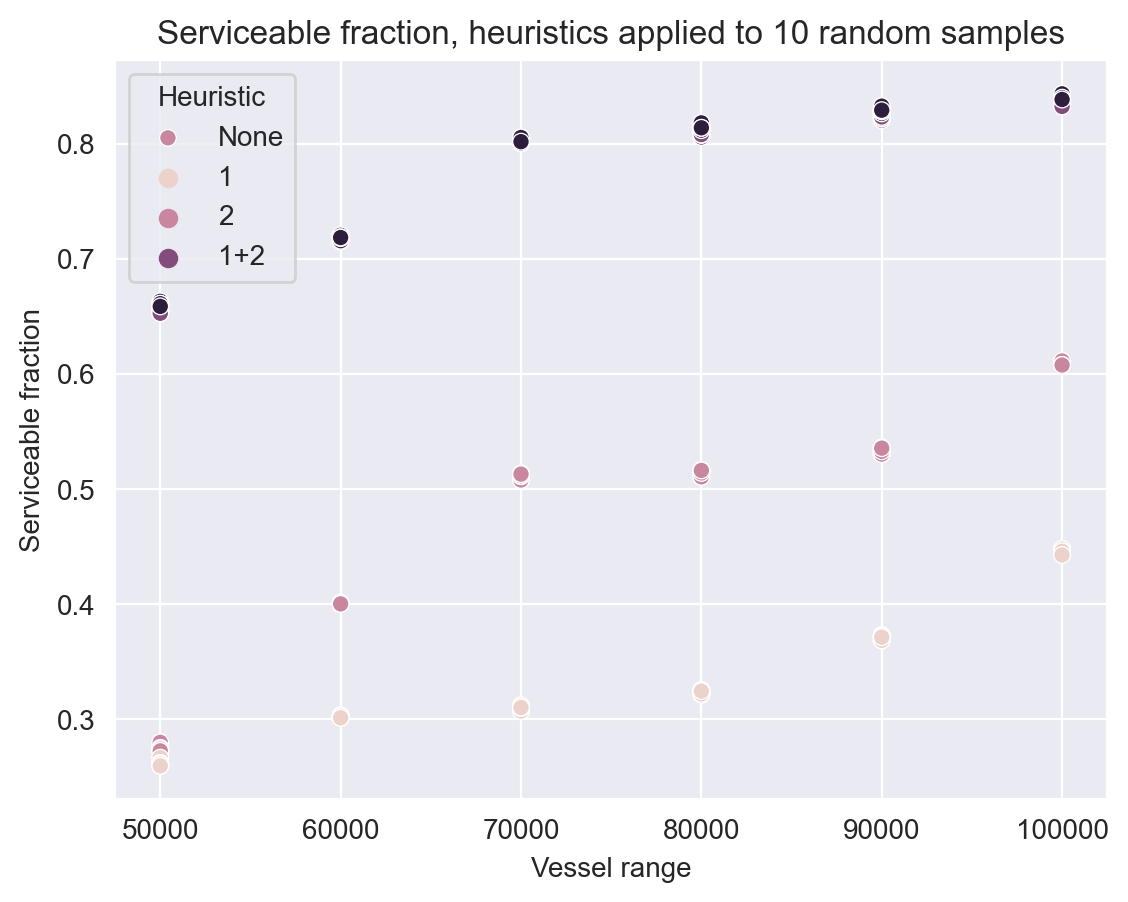

In [20]:
fig, ax = plt.subplots(dpi=200)
sns.scatterplot(x='r', y='serviceable_fraction', hue='additional_nodes', data=df, ax=ax)
plt.title("Serviceable fraction heuristics applied to 10 random samples")
plt.ylabel("Serviceable fraction")
plt.xlabel("Vessel range")
plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])
plt.show()

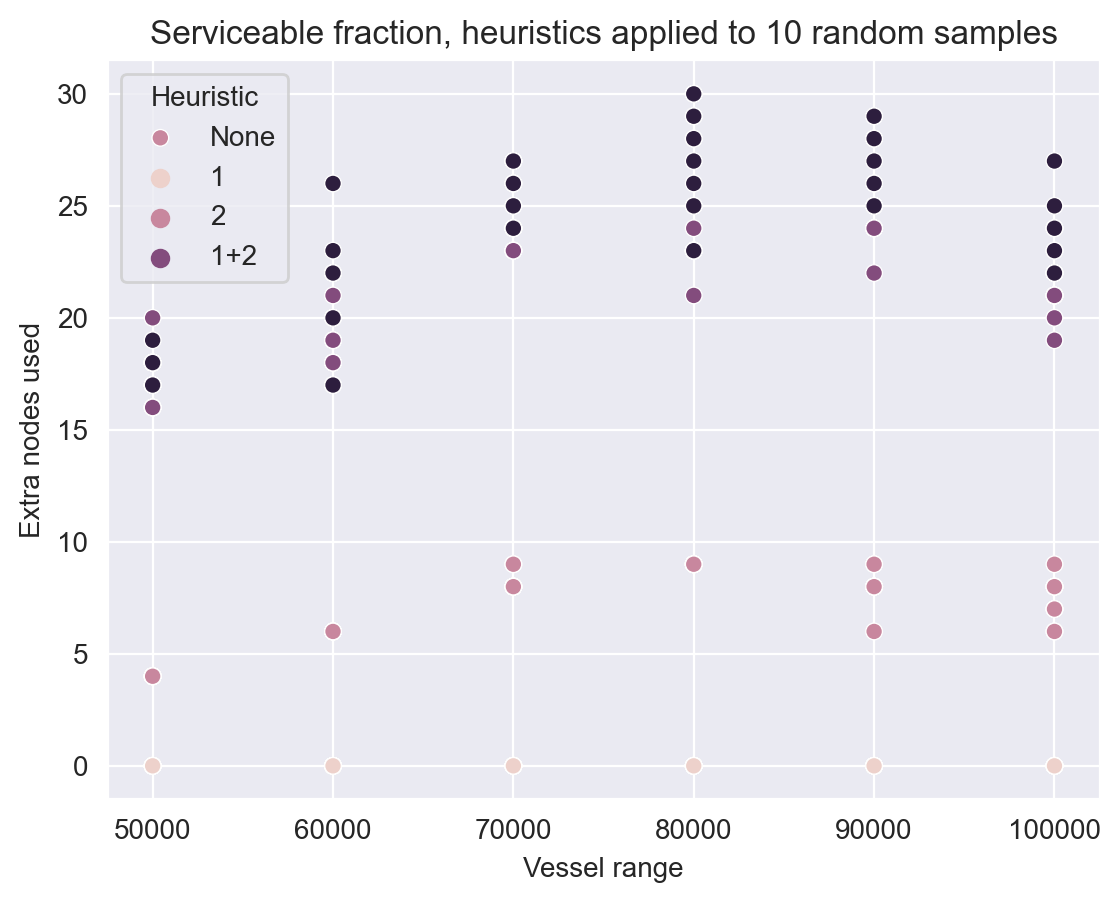

In [21]:
fig, ax = plt.subplots(dpi=200)
sns.scatterplot(x='r', y='extra_nodes_used', hue='additional_nodes', data=df, ax=ax)
plt.title("Serviceable fraction, heuristics applied to 10 random samples")
plt.ylabel("Extra nodes used")
plt.xlabel("Vessel range")
plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])
plt.show()

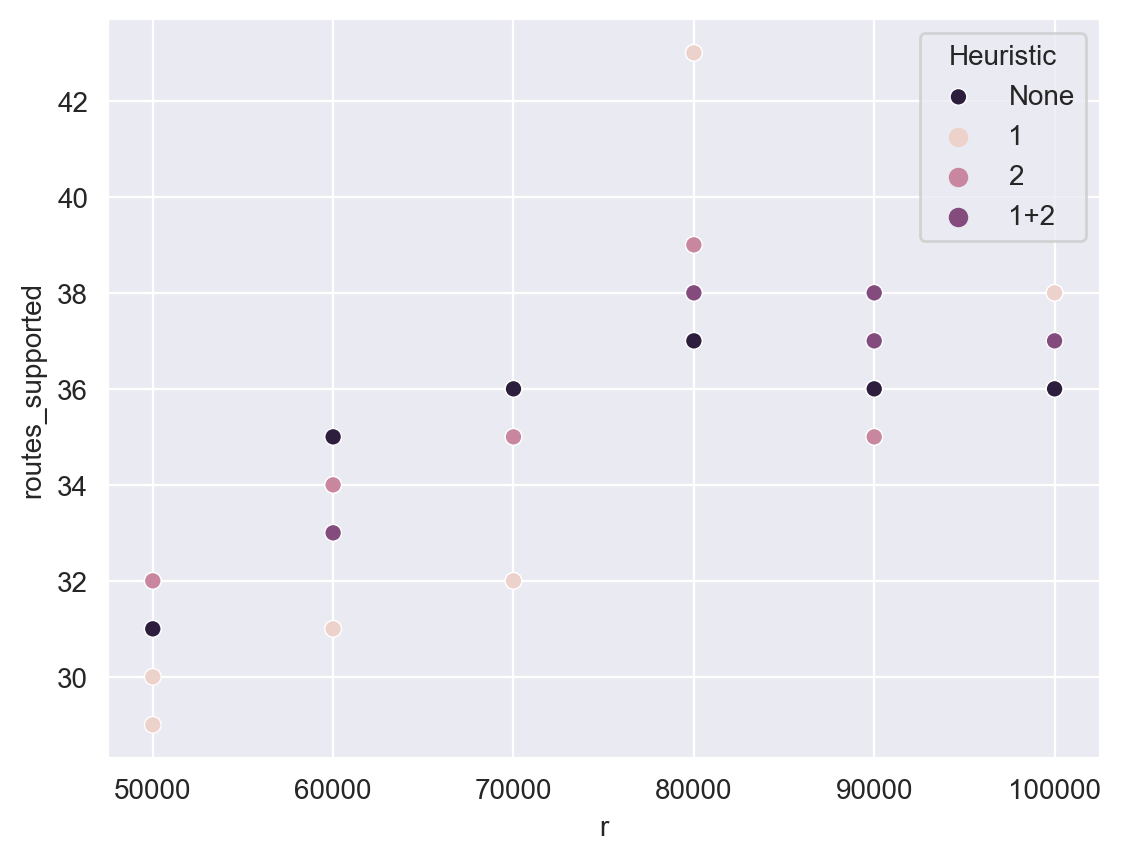

In [13]:
plt.subplots(dpi=200)
sns.scatterplot(x='r', y='routes_supported', hue='additional_nodes', data=df)
plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])


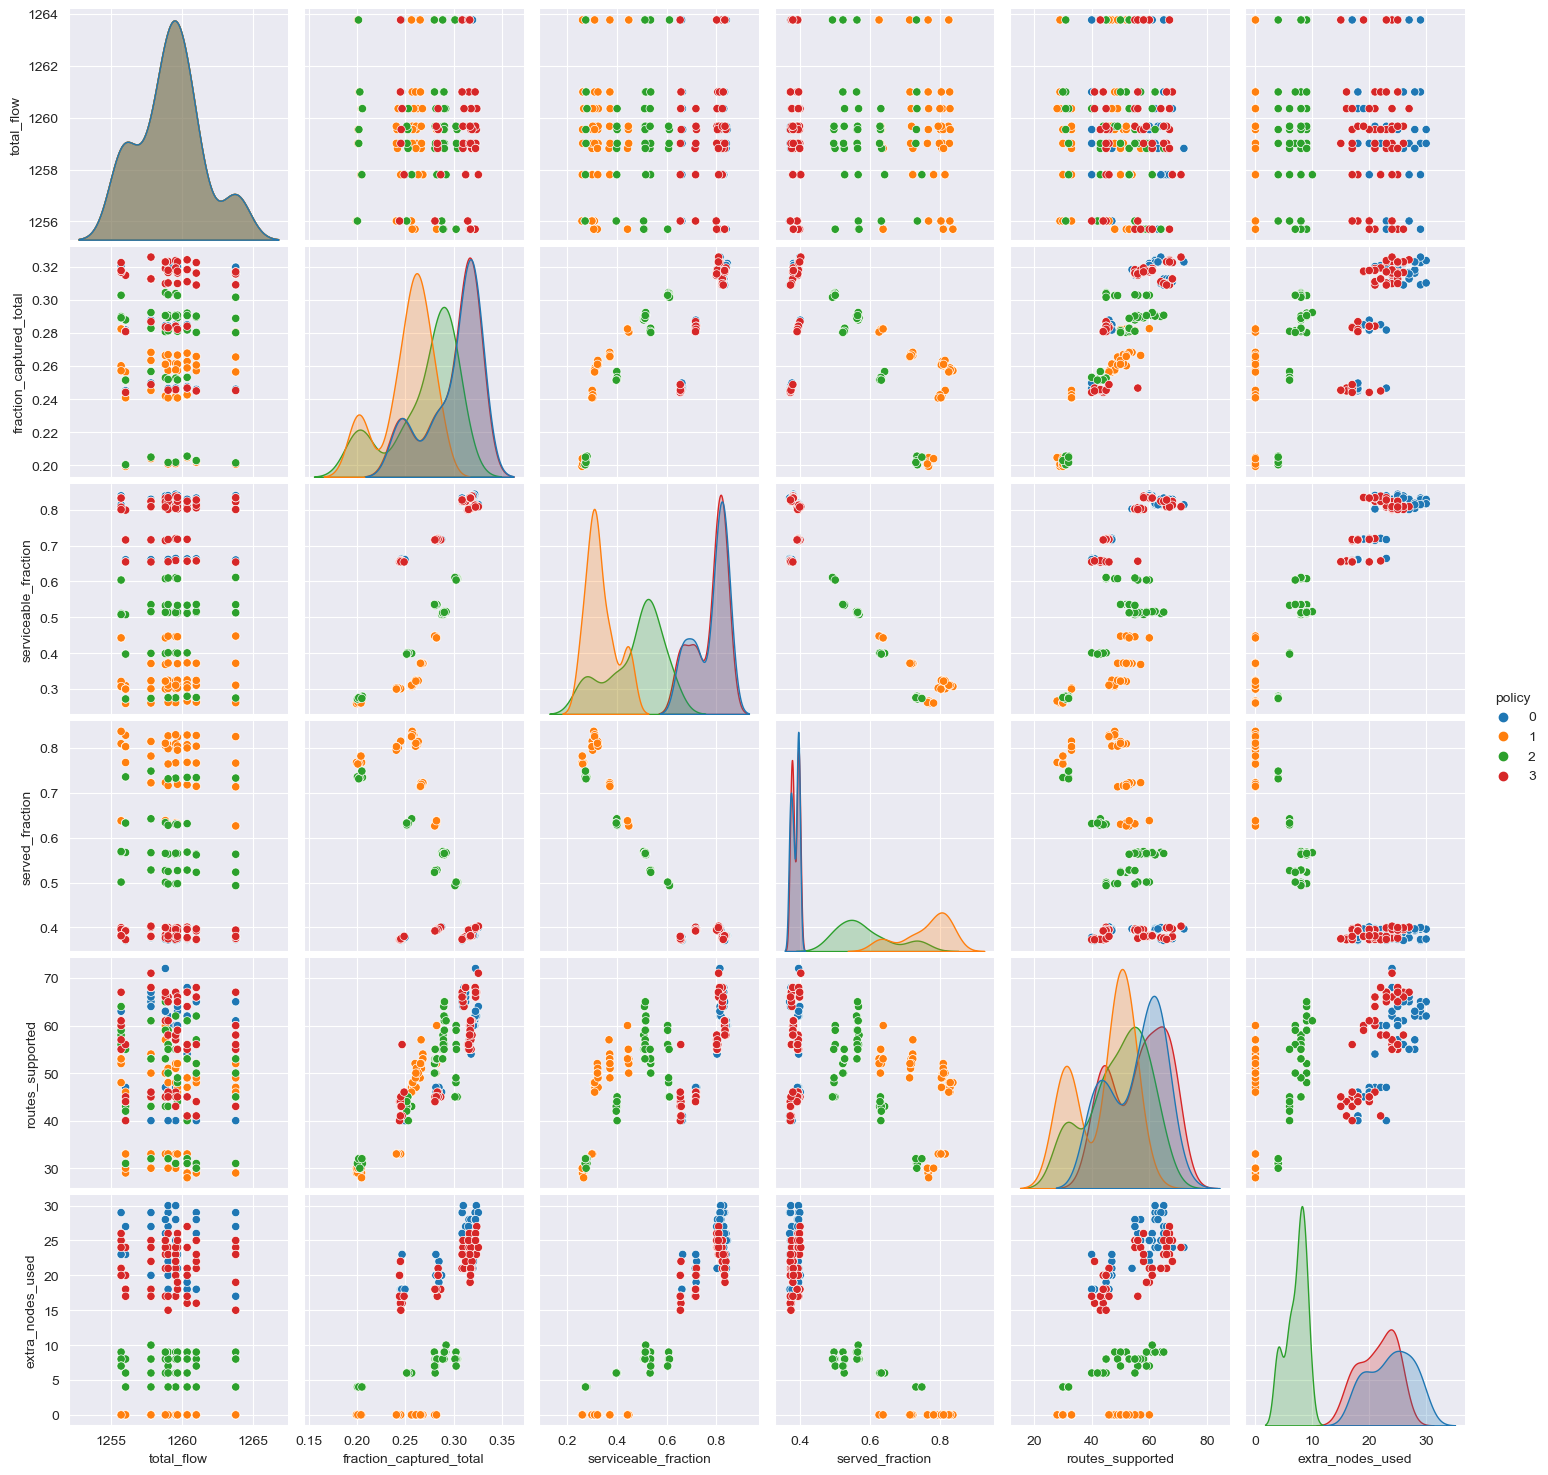

In [14]:
policies = experiments["policy"]
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies == policy, "policy"] = str(i)

data = pd.DataFrame(outcomes)
data["policy"] = policies
sns.pairplot(data, hue="policy", vars=list(outcomes.keys()))
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


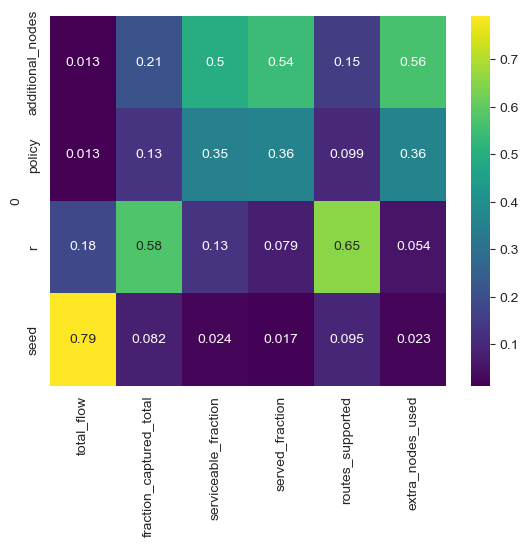

In [23]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()